In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import random

https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 64


# MNIST Dataset
transform = transforms.Compose(
  [
    transforms.ToTensor()
  ]
)
  
train_dataset = datasets.MNIST(root='./data1/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data1/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

I:\Anaconda3\envs\hhx\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:

def aff(e):
  return e * 2 - 1

transform = transforms.Compose(
  [
    transforms.ToTensor(),
    aff,
    transforms.RandomHorizontalFlip(p=0.5)
  ]
)

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Files already downloaded and verified


In [5]:
def img_show(img):
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.permute(1,2,0)/2+0.5)

In [6]:
class Generator(nn.Module):
  def __init__(self, g_input_dim, g_output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(g_input_dim, 256)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
    self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
  # forward method
  def forward(self, x): 
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
  def __init__(self, d_input_dim):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(d_input_dim, 1024)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
    self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.dropout(x, 0.3)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.dropout(x, 0.3)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = F.dropout(x, 0.3)
    return torch.sigmoid(self.fc4(x))

In [7]:
class Generator1(nn.Module):
  def __init__(self, g_input_dim):
    super(Generator1, self).__init__()
    self.fc = nn.Linear(g_input_dim, 8*7*7)
    self.up1 = self._gen_seq(8, 16)
    self.up2 = self._gen_seq(16, 16)
    self.up3 = self._gen_seq(16, 1, False)
  
  def _gen_seq(self, in_channels, out_channels, has_up=True):
    if has_up:
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.Upsample(scale_factor=2))
    else:
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1))

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc(x))
    x = x.reshape(-1, 8, 7, 7)
    x = F.leaky_relu(self.up1(x))
    x = F.leaky_relu(self.up2(x))
    return torch.sigmoid(self.up3(x))

class Discriminator1(nn.Module):
  def __init__(self):
    super(Discriminator1, self).__init__()
    self.down1 = self._gen_seq(1, 16)
    self.down2 = self._gen_seq(16, 16)
    self.fc1 = nn.Linear(16*7*7, 256)
    self.fc2 = nn.Linear(256, 1)
    
  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.MaxPool2d(2)
    )

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.down1(x))
    x = F.dropout(x, 0.3)
    x = F.leaky_relu(self.down2(x))
    x = F.dropout(x, 0.3)
    x = x.reshape(-1, 16*7*7)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, 0.3)
    return torch.sigmoid(self.fc2(x))

In [8]:
class Generator2(nn.Module):
  def __init__(self, g_input_dim):
    super(Generator2, self).__init__()
    self.fc = nn.Linear(g_input_dim, 16*8*8)
    self.up1 = self._gen_seq(16, 32)
    self.up2 = self._gen_seq(32, 32)
    self.up3 = self._gen_seq(32, 3, False)
  
  def _gen_seq(self, in_channels, out_channels, has_up=True):
    if has_up:
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.Upsample(scale_factor=2))
    else:
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1))

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc(x))
    x = x.reshape(-1, 16, 8, 8)
    x = F.leaky_relu(self.up1(x))
    x = F.leaky_relu(self.up2(x))
    return torch.sigmoid(self.up3(x))

class Discriminator2(nn.Module):
  def __init__(self):
    super(Discriminator2, self).__init__()
    self.down1 = self._gen_seq(3, 16)
    self.down2 = self._gen_seq(16, 16)
    self.fc1 = nn.Linear(16*8*8, 256)
    self.fc2 = nn.Linear(256, 1)
    
  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.MaxPool2d(2)
    )

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.down1(x))
    x = F.dropout(x, 0.3)
    x = F.leaky_relu(self.down2(x))
    x = F.dropout(x, 0.3)
    x = x.reshape(-1, 16*8*8)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, 0.3)
    return torch.sigmoid(self.fc2(x))

In [12]:
class Generator3(nn.Module):
  def __init__(self, g_input_dim):
    super(Generator3, self).__init__()
    self.fc = nn.Linear(g_input_dim, 4096)
    
    self.up1 = self._gen_seq(256, 256)
    self.up2 = self._gen_seq(256, 128)
    self.up3 = self._gen_seq(128, 64)
    self.fin_conv = nn.Conv2d(64, 3, 3, padding=1)
  
  def _gen_seq(self, in_channels, out_channels, has_up=True):
    if has_up:
      return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.Upsample(scale_factor=2)
      )
    else:
      return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 3, padding=1))

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.fc(x))
    x = x.reshape(-1, 256, 4, 4)
    x = F.leaky_relu(self.up1(x))
    x = F.leaky_relu(self.up2(x))
    x = F.leaky_relu(self.up3(x))
    return torch.tanh(self.fin_conv(x))

class Discriminator3(nn.Module):
  def __init__(self):
    super(Discriminator3, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.down2 = self._gen_seq(64, 128)
    self.down3 = self._gen_seq(128, 128)
    self.down4 = self._gen_seq(128, 256) # 4*4*256
    self.fc1 = nn.Linear(4*4*256, 1)
    
  def _gen_seq(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.MaxPool2d(2)
    )

  # forward method
  def forward(self, x):
    x = F.leaky_relu(self.conv1(x))
    x = F.leaky_relu(self.down2(x))
    x = F.leaky_relu(self.down3(x))
    x = F.leaky_relu(self.down4(x))
    x = x.reshape(-1, 4*4*256)
    x = F.dropout(x, 0.4)
    x = F.leaky_relu(self.fc1(x))
    return torch.sigmoid(x)

In [13]:
class Generator4(nn.Module):
	def __init__(self, g_input_dim):
		super(Generator4, self).__init__()
		self.fc1 = nn.Linear(g_input_dim, 4*4*512)
		self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
		self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
		self.deconv3 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
		self.bn1 = nn.BatchNorm2d(512)
		self.bn2 = nn.BatchNorm2d(256)
		self.bn3 = nn.BatchNorm2d(128)

	def forward(self, z):
		x = self.fc1(z).view(-1, 512, 4, 4)
		x = self.bn1(x) 
		x = F.relu(x)
		x = F.leaky_relu(x)

		x = self.deconv1(x)
		x = self.bn2(x)
		x = F.leaky_relu(x)
		
		x = self.deconv2(x)
		x = self.bn3(x)
		x = F.leaky_relu(x)
		
		x = self.deconv3(x)
		x = torch.tanh(x)
		return x

class Discriminator4(nn.Module):
	def __init__(self):
		super(Discriminator4, self).__init__()
		self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
		self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
		self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
		self.bn1 = nn.BatchNorm2d(128)
		self.bn2 = nn.BatchNorm2d(256)
		self.fc1 = nn.Linear(4*4*256, 1)

	def forward(self, x):
		x = self.conv1(x)
		x = F.leaky_relu(x)

		x = self.conv2(x)
		x = self.bn1(x)
		x = F.leaky_relu(x)

		x = self.conv3(x)
		x = self.bn2(x)
		x = F.leaky_relu(x)

		x = x.view(-1, 4*4*256)
		x = self.fc1(x)
		x = torch.sigmoid(x)
		return x

In [14]:
# build network
z_dim = 100
# mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator3(g_input_dim = z_dim).to(device)
D = Discriminator2().to(device)

In [15]:
def gen_fake_inputs(batch):
  return Variable(torch.randn(batch, z_dim).to(device))

def gen_labels(batch, value):
  return Variable((torch.zeros(batch, 1) + value).to(device))

In [16]:
# loss
criterion = nn.BCELoss()

# optimizer
g_lr = 0.0002
d_lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = g_lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = d_lr)

In [17]:
def D_train(x):
  #=======================Train the discriminator=======================#
  D.zero_grad()

  # train discriminator on real
  _bs = x.shape[0]
  x_real, y_real = Variable(x.to(device)), gen_labels(_bs, 1)

  D_output = D(x_real)
  D_real_loss = criterion(D_output, y_real)

  # train discriminator on fake
  z = gen_fake_inputs(_bs)
  x_fake, y_fake = G(z), gen_labels(_bs, 0)

  D_output = D(x_fake)
  D_fake_loss = criterion(D_output, y_fake)

  # gradient backprop & optimize ONLY D's parameters
  D_loss = D_real_loss + D_fake_loss
  D_loss.backward()
  D_optimizer.step()
      
  return  D_loss.data.item()

In [18]:
def G_train():
  #=======================Train the generator=======================#
  G.zero_grad()

  z = gen_fake_inputs(bs)
  y = gen_labels(bs, 1)

  G_output = G(z)
  D_output = D(G_output)
  G_loss = criterion(D_output, y)

  # gradient backprop & optimize ONLY G's parameters
  G_loss.backward()
  G_optimizer.step()
      
  return G_loss.data.item()

In [19]:
fake_len = 8
fake_inputs = gen_fake_inputs(fake_len)

def gen_fake_img():
  b = G(fake_inputs)
  for i in range(0, fake_len):
    b_n = b[i].cpu().detach()
    plt.subplot(1, fake_len, i+1)
    img_show(b_n)
  plt.show()

In [24]:
def test_fake_efficiency(is_round = False):
  e = 10
  s = 0
  for i in range(e):
    a = gen_fake_inputs(bs)
    b = G(a)
    D_output = D(b)
    if is_round:
      D_output = torch.round(D_output)
    D_true = torch.sum(D_output).item() / bs
    s += D_true
  return s / e
  

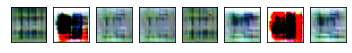

In [25]:
gen_fake_img()

In [26]:
test_fake_efficiency()

0.4600348353385925

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[1/200]: loss_d: 1.028, loss_g: 1.323, d_error: 0.380412, d_error_round: 0.264


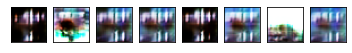

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[2/200]: loss_d: 0.983, loss_g: 1.401, d_error: 0.307188, d_error_round: 0.191


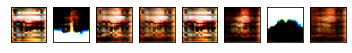

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[3/200]: loss_d: 0.874, loss_g: 1.662, d_error: 0.273509, d_error_round: 0.152


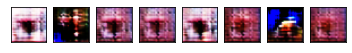

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[4/200]: loss_d: 0.954, loss_g: 1.545, d_error: 0.312739, d_error_round: 0.197


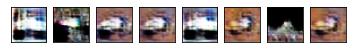

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[5/200]: loss_d: 0.937, loss_g: 1.512, d_error: 0.396127, d_error_round: 0.297


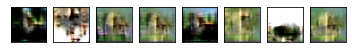

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[6/200]: loss_d: 0.983, loss_g: 1.407, d_error: 0.298987, d_error_round: 0.175


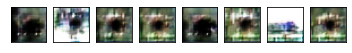

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[7/200]: loss_d: 1.085, loss_g: 1.251, d_error: 0.350413, d_error_round: 0.244


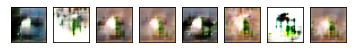

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[8/200]: loss_d: 1.056, loss_g: 1.288, d_error: 0.276147, d_error_round: 0.102


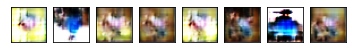

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[9/200]: loss_d: 0.995, loss_g: 1.466, d_error: 0.325232, d_error_round: 0.166


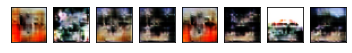

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[10/200]: loss_d: 1.055, loss_g: 1.314, d_error: 0.396982, d_error_round: 0.280


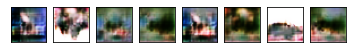

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[11/200]: loss_d: 1.090, loss_g: 1.226, d_error: 0.318927, d_error_round: 0.189


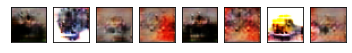

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[12/200]: loss_d: 1.045, loss_g: 1.337, d_error: 0.357244, d_error_round: 0.233


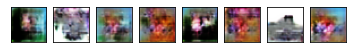

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[13/200]: loss_d: 1.079, loss_g: 1.275, d_error: 0.346386, d_error_round: 0.200


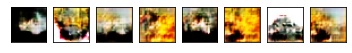

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[14/200]: loss_d: 1.061, loss_g: 1.305, d_error: 0.358946, d_error_round: 0.186


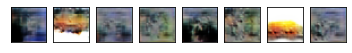

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[15/200]: loss_d: 1.094, loss_g: 1.249, d_error: 0.368816, d_error_round: 0.202


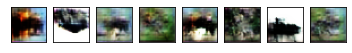

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[16/200]: loss_d: 1.101, loss_g: 1.233, d_error: 0.408932, d_error_round: 0.303


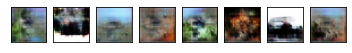

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[17/200]: loss_d: 1.073, loss_g: 1.250, d_error: 0.342926, d_error_round: 0.198


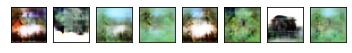

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[18/200]: loss_d: 1.059, loss_g: 1.309, d_error: 0.390130, d_error_round: 0.312


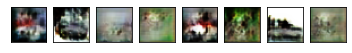

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[19/200]: loss_d: 1.125, loss_g: 1.205, d_error: 0.388708, d_error_round: 0.248


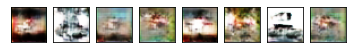

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[20/200]: loss_d: 1.151, loss_g: 1.135, d_error: 0.378556, d_error_round: 0.306


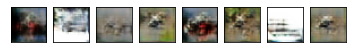

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[21/200]: loss_d: 1.094, loss_g: 1.229, d_error: 0.375985, d_error_round: 0.275


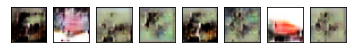

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[22/200]: loss_d: 1.117, loss_g: 1.215, d_error: 0.432370, d_error_round: 0.331


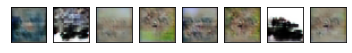

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[23/200]: loss_d: 1.096, loss_g: 1.237, d_error: 0.383341, d_error_round: 0.286


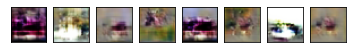

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[24/200]: loss_d: 1.076, loss_g: 1.304, d_error: 0.419207, d_error_round: 0.316


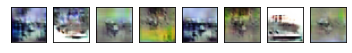

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[25/200]: loss_d: 1.104, loss_g: 1.191, d_error: 0.341649, d_error_round: 0.244


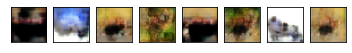

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[26/200]: loss_d: 1.121, loss_g: 1.231, d_error: 0.329940, d_error_round: 0.239


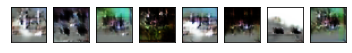

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[27/200]: loss_d: 1.142, loss_g: 1.173, d_error: 0.372024, d_error_round: 0.248


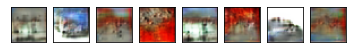

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[28/200]: loss_d: 1.125, loss_g: 1.178, d_error: 0.358579, d_error_round: 0.239


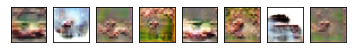

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[29/200]: loss_d: 1.114, loss_g: 1.206, d_error: 0.368078, d_error_round: 0.237


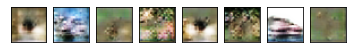

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[30/200]: loss_d: 1.099, loss_g: 1.234, d_error: 0.332316, d_error_round: 0.183


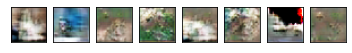

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[31/200]: loss_d: 1.122, loss_g: 1.160, d_error: 0.365269, d_error_round: 0.214


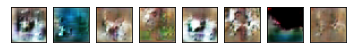

||||||||||

KeyboardInterrupt: 

In [29]:
n_epoch = 200
d_error_rate = 1


for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  for batch_idx, (x, _) in enumerate(train_loader):

    if batch_idx % 10 == 0:
      print('|', end='')
    
    # d_error_rate = test_fake_efficiency()

    # if d_error_rate > random.normalvariate(0.5, 0.1):
    #   D_losses.append(D_train(x))
    # else:
    #   G_losses.append(G_train())

    D_losses.append(D_train(x))
    G_losses.append(G_train())

    # if batch_idx % 150 == 0:
    #   print('%.3f ' % d_error_rate)
    #   gen_fake_img()
  

  ld = 0
  lg = 0
  if len(D_losses) > 0:
    ld = torch.mean(torch.FloatTensor(D_losses))
  if len(G_losses) > 0:
    lg = torch.mean(torch.FloatTensor(G_losses))

  print()
  d_error_rate = test_fake_efficiency()
  d_error_rate_round = test_fake_efficiency(True)
  print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, d_error: %.6f, d_error_round: %.3f' % (
    (epoch), n_epoch, ld, lg, d_error_rate, d_error_rate_round))

  torch.save(G.state_dict(), 'generator3.pth')
  torch.save(D.state_dict(), 'discriminator3.pth')
  
  gen_fake_img()
  # print(G.state_dict()['up2.0.weight'][0,10])

I:\Anaconda3\envs\hhx\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1/200]: loss_d: 0.425, loss_g: 3.567
[2/200]: loss_d: 0.503, loss_g: 2.742
[3/200]: loss_d: 0.519, loss_g: 2.672
[4/200]: loss_d: 0.567, loss_g: 2.409
[5/200]: loss_d: 0.630, loss_g: 2.234


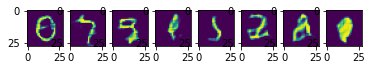

[6/200]: loss_d: 0.661, loss_g: 2.153
[7/200]: loss_d: 0.662, loss_g: 2.142
[8/200]: loss_d: 0.673, loss_g: 2.120
[9/200]: loss_d: 0.674, loss_g: 2.098
[10/200]: loss_d: 0.679, loss_g: 2.105


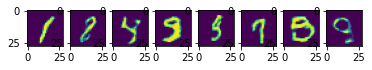

[11/200]: loss_d: 0.683, loss_g: 2.104
[12/200]: loss_d: 0.684, loss_g: 2.088


KeyboardInterrupt: 

In [88]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
  D_losses, G_losses = [], []
  for batch_idx, (x, _) in enumerate(train_loader):
    D_losses.append(D_train(x))
    G_losses.append(G_train(x))

  print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
    (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
  if epoch % 5 == 0:
    gen_fake_img()
    print(test_fake_efficiency())

[1/200]: loss_d: 0.054, loss_g: 6.533
[2/200]: loss_d: 0.037, loss_g: 6.820
[3/200]: loss_d: 0.273, loss_g: 4.577
[4/200]: loss_d: 0.658, loss_g: 2.307
[5/200]: loss_d: 0.722, loss_g: 2.032
[6/200]: loss_d: 0.674, loss_g: 2.227
[7/200]: loss_d: 0.636, loss_g: 2.373
[8/200]: loss_d: 0.620, loss_g: 2.371
[9/200]: loss_d: 0.625, loss_g: 2.325
[10/200]: loss_d: 0.636, loss_g: 2.290


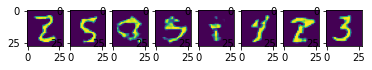

[11/200]: loss_d: 0.643, loss_g: 2.249
[12/200]: loss_d: 0.655, loss_g: 2.223
[13/200]: loss_d: 0.661, loss_g: 2.193
[14/200]: loss_d: 0.670, loss_g: 2.182
[15/200]: loss_d: 0.680, loss_g: 2.171
[16/200]: loss_d: 0.683, loss_g: 2.157
[17/200]: loss_d: 0.689, loss_g: 2.165
[18/200]: loss_d: 0.687, loss_g: 2.159
[19/200]: loss_d: 0.690, loss_g: 2.150
[20/200]: loss_d: 0.694, loss_g: 2.162


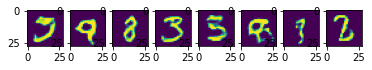

[21/200]: loss_d: 0.694, loss_g: 2.139
[22/200]: loss_d: 0.693, loss_g: 2.153
[23/200]: loss_d: 0.691, loss_g: 2.170
[24/200]: loss_d: 0.693, loss_g: 2.170
[25/200]: loss_d: 0.692, loss_g: 2.166
[26/200]: loss_d: 0.684, loss_g: 2.185
[27/200]: loss_d: 0.683, loss_g: 2.185
[28/200]: loss_d: 0.680, loss_g: 2.189
[29/200]: loss_d: 0.683, loss_g: 2.203
[30/200]: loss_d: 0.682, loss_g: 2.196


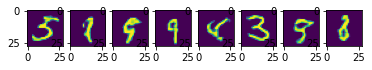

[31/200]: loss_d: 0.674, loss_g: 2.216
[32/200]: loss_d: 0.679, loss_g: 2.217
[33/200]: loss_d: 0.674, loss_g: 2.220
[34/200]: loss_d: 0.672, loss_g: 2.234
[35/200]: loss_d: 0.669, loss_g: 2.269
[36/200]: loss_d: 0.675, loss_g: 2.231
[37/200]: loss_d: 0.669, loss_g: 2.260
[38/200]: loss_d: 0.668, loss_g: 2.254
[39/200]: loss_d: 0.664, loss_g: 2.262
[40/200]: loss_d: 0.665, loss_g: 2.269


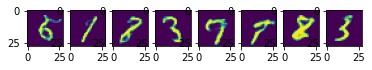

[41/200]: loss_d: 0.659, loss_g: 2.271
[42/200]: loss_d: 0.652, loss_g: 2.283
[43/200]: loss_d: 0.657, loss_g: 2.300
[44/200]: loss_d: 0.649, loss_g: 2.320
[45/200]: loss_d: 0.649, loss_g: 2.319
[46/200]: loss_d: 0.644, loss_g: 2.328
[47/200]: loss_d: 0.646, loss_g: 2.329
[48/200]: loss_d: 0.647, loss_g: 2.343
[49/200]: loss_d: 0.641, loss_g: 2.338
[50/200]: loss_d: 0.641, loss_g: 2.351


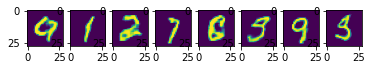

[51/200]: loss_d: 0.634, loss_g: 2.359
[52/200]: loss_d: 0.637, loss_g: 2.348
[53/200]: loss_d: 0.630, loss_g: 2.375
[54/200]: loss_d: 0.631, loss_g: 2.362
[55/200]: loss_d: 0.626, loss_g: 2.399
[56/200]: loss_d: 0.627, loss_g: 2.395
[57/200]: loss_d: 0.619, loss_g: 2.417
[58/200]: loss_d: 0.619, loss_g: 2.406
[59/200]: loss_d: 0.615, loss_g: 2.420
[60/200]: loss_d: 0.617, loss_g: 2.434


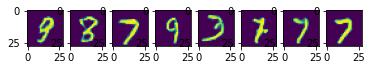

[61/200]: loss_d: 0.607, loss_g: 2.457
[62/200]: loss_d: 0.606, loss_g: 2.452
[63/200]: loss_d: 0.609, loss_g: 2.460
[64/200]: loss_d: 0.600, loss_g: 2.481
[65/200]: loss_d: 0.603, loss_g: 2.491
[66/200]: loss_d: 0.605, loss_g: 2.464
[67/200]: loss_d: 0.603, loss_g: 2.484
[68/200]: loss_d: 0.598, loss_g: 2.483
[69/200]: loss_d: 0.598, loss_g: 2.489
[70/200]: loss_d: 0.592, loss_g: 2.509


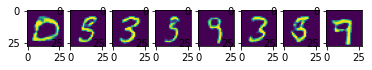

[71/200]: loss_d: 0.594, loss_g: 2.508
[72/200]: loss_d: 0.585, loss_g: 2.542
[73/200]: loss_d: 0.585, loss_g: 2.543
[74/200]: loss_d: 0.583, loss_g: 2.543
[75/200]: loss_d: 0.579, loss_g: 2.581
[76/200]: loss_d: 0.579, loss_g: 2.557
[77/200]: loss_d: 0.575, loss_g: 2.572
[78/200]: loss_d: 0.573, loss_g: 2.573
[79/200]: loss_d: 0.567, loss_g: 2.602
[80/200]: loss_d: 0.565, loss_g: 2.600


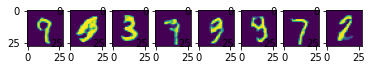

[81/200]: loss_d: 0.564, loss_g: 2.592
[82/200]: loss_d: 0.565, loss_g: 2.597
[83/200]: loss_d: 0.566, loss_g: 2.598
[84/200]: loss_d: 0.560, loss_g: 2.637
[85/200]: loss_d: 0.559, loss_g: 2.605
[86/200]: loss_d: 0.554, loss_g: 2.647
[87/200]: loss_d: 0.558, loss_g: 2.601
[88/200]: loss_d: 0.557, loss_g: 2.612
[89/200]: loss_d: 0.563, loss_g: 2.613
[90/200]: loss_d: 0.550, loss_g: 2.647


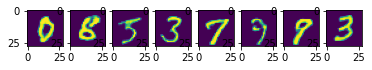

[91/200]: loss_d: 0.554, loss_g: 2.629
[92/200]: loss_d: 0.552, loss_g: 2.642
[93/200]: loss_d: 0.553, loss_g: 2.631


KeyboardInterrupt: 

In [74]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
  D_losses, G_losses = [], []
  for batch_idx, (x, _) in enumerate(train_loader):
    D_losses.append(D_train(x))
    G_losses.append(G_train(x))

  print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
    (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
  if epoch % 5 == 0:
    gen_fake_img()